In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# Load Datasets
historical_df = pd.read_csv('historical_data.csv')
sentiment_df = pd.read_csv('fear_greed_index.csv')
hist.head()
sent.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [10]:
# Clean Historical Data
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], dayfirst=True)
historical_df['Date'] = historical_df['Timestamp IST'].dt.date

In [11]:
# Aggregate Daily Metrics
daily_trader_stats = historical_df.groupby('Date').agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Trade ID': 'count',
    'Fee': 'sum'
}).reset_index()

daily_trader_stats.rename(columns={'Trade ID': 'Trade_Count', 'Size USD': 'Volume_USD'}, inplace=True)

In [13]:
# Clean Sentiment Data
sentiment_df['Date'] = pd.to_datetime(sentiment_df['date']).dt.date
sentiment_df = sentiment_df[['Date', 'value', 'classification']]
sentiment_df.rename(columns={'value': 'Sentiment_Value', 'classification': 'Sentiment_Class'}, inplace=True)

In [14]:
#  Merge into a Master Dataframe
df = pd.merge(daily_trader_stats, sentiment_df, on='Date', how='inner')
df = df.sort_values('Date')

In [15]:
print(f"Merged Dataset created with {len(df)} days of data.")
df.head()

Merged Dataset created with 479 days of data.


,Date,Closed PnL,Volume_USD,Trade_Count,Fee,Sentiment_Value,Sentiment_Class
0,2023-05-01,0.000000,477.00,3,0.000000,63,Greed
1,2023-12-05,0.000000,50005.83,9,12.501455,75,Extreme Greed
2,2023-12-14,-205.434737,113203.35,11,28.300831,72,Greed
3,2023-12-15,-24.632034,10609.95,2,2.652489,70,Greed
4,2023-12-16,0.000000,15348.77,3,3.837189,67,Greed


In [18]:
# Define the logical order of market sentiment
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# 1. Aggregate main performance metrics
performance_summary = df.groupby('Sentiment_Class').agg({
    'Closed PnL': ['mean', 'std'],
    'Volume_USD': 'mean',
    'Trade_Count': 'mean'
}).reindex(sentiment_order)

# 2. Calculate Daily Win Rate (Avoiding the DeprecationWarning)
# We create a boolean Series (True for profit, False for loss) 
# and then group it by sentiment to find the mean (percentage of True)
win_rate = (df['Closed PnL'] > 0).groupby(df['Sentiment_Class']).mean().reindex(sentiment_order)

# 3. Add Win Rate to the summary table
performance_summary['Win_Rate'] = win_rate

print("--- Performance Summary by Sentiment ---")
display(performance_summary)

--- Performance Summary by Sentiment ---


Closed PnL                   Volume_USD  Trade_Count  \
                         mean            std          mean         mean   
Sentiment_Class                                                           
Extreme Fear     52793.589178  101262.394065  8.177447e+06  1528.571429   
Fear             36891.818040   96611.848503  5.311261e+06   679.527473   
Neutral          19297.323516   37995.209071  2.690180e+06   562.477612   
Greed            11140.566181   62427.957949  1.495246e+06   260.637306   
Extreme Greed    23817.292199   72827.301581  1.091800e+06   350.807018   

                 Win_Rate  
                           
Sentiment_Class            
Extreme Fear     0.642857  
Fear             0.736264  
Neutral          0.671642  
Greed            0.725389  
Extreme Greed    0.877193

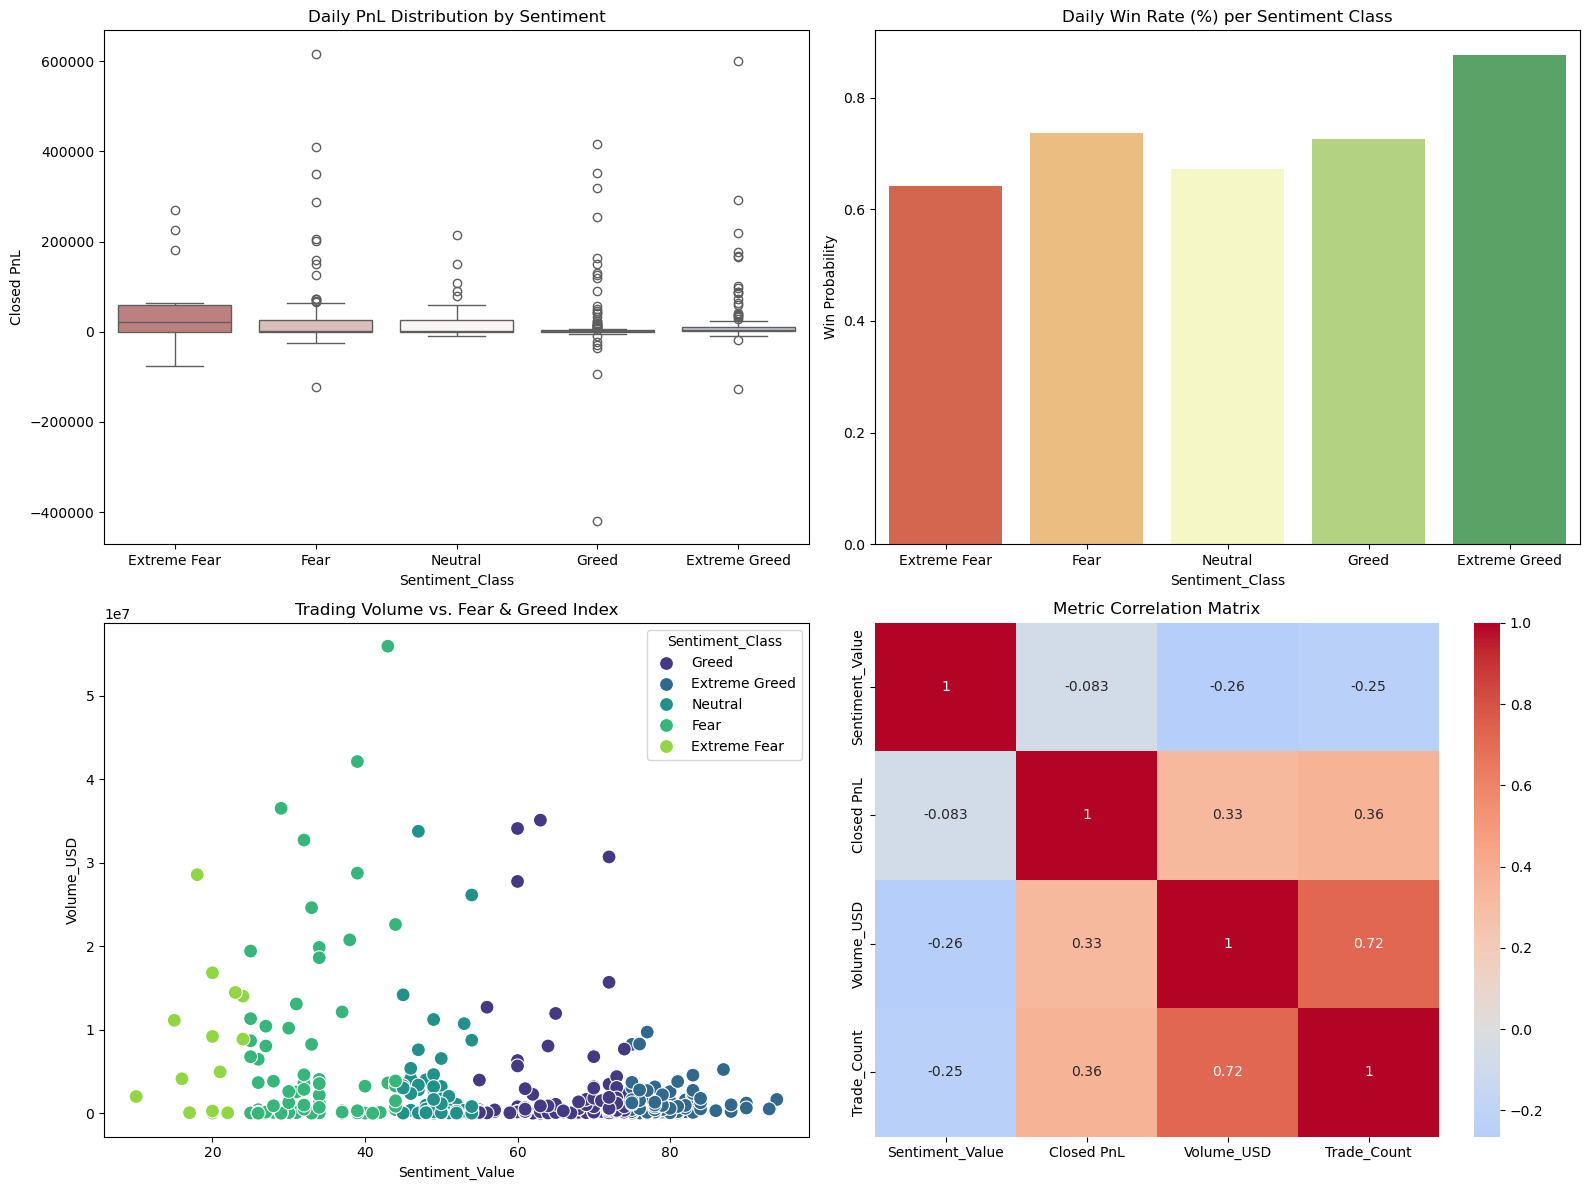

In [19]:
# Create a dashboard with 2x2 plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. PnL Distribution by Sentiment 
sns.boxplot(
    ax=axes[0,0], 
    x='Sentiment_Class', 
    y='Closed PnL', 
    data=df, 
    order=sentiment_order, 
    hue='Sentiment_Class',  
    palette='vlag', 
    legend=False             
)
axes[0,0].set_title('Daily PnL Distribution by Sentiment')

# 2. Win Rate by Sentiment 
sns.barplot(
    ax=axes[0,1], 
    x=win_rate.index, 
    y=win_rate.values, 
    hue=win_rate.index,      
    palette='RdYlGn', 
    legend=False             
)
axes[0,1].set_title('Daily Win Rate (%) per Sentiment Class')
axes[0,1].set_ylabel('Win Probability')

# 3. Volume vs Sentiment Value 
sns.scatterplot(
    ax=axes[1,0], 
    x='Sentiment_Value', 
    y='Volume_USD', 
    hue='Sentiment_Class', 
    data=df, 
    palette='viridis', 
    s=100
)
axes[1,0].set_title('Trading Volume vs. Fear & Greed Index')

# 4. Correlation Heatmap
corr = df[['Sentiment_Value', 'Closed PnL', 'Volume_USD', 'Trade_Count']].corr()
sns.heatmap(ax=axes[1,1], annot=True, data=corr, cmap='coolwarm', center=0)
axes[1,1].set_title('Metric Correlation Matrix')

plt.tight_layout()
plt.show()